# Import all the Packages you will need 

In [229]:
import pyodbc
from dotenv import dotenv_values
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import statistics as stat
import warnings
import os

warnings.filterwarnings('ignore')

# Load the Environments and get the variables form your.env file 

In [230]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

In [231]:
conn_str =f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

# Make the Connection and Read the Tables

In [232]:
connection = pyodbc.connect(conn_str)

query1 = "Select * from LP1_startup_funding2020"
data2020 = pd.read_sql(query1, connection)

query2 = "Select * from LP1_startup_funding2021"
data2021 = pd.read_sql(query2, connection)

# Read the csv 

In [233]:
df2018 = pd.read_csv('startup_funding2018.csv')

df2019 = pd.read_csv('startup_funding2019.csv')

# Drop Colunms that are not going to be needed in the project and also the Empty Colunms 

In [234]:

df2019.drop(['Founded', 'Founders', 'Investor'], axis=1, inplace=True)
data2020.drop(['Founded', 'Founders', 'Investor'], axis=1, inplace=True)
data2021.drop(['Founded', 'Founders', 'Investor'], axis=1, inplace=True)


In [235]:
df2018 = df2018.rename(columns={'Company Name': 'Company_Brand', 'Round/Series': 'Stage', 'Industry': 'Sector', 'Amount': 'Amount', 'About Company': 'BIO', 'Location':'HeadQuarter'})
df2019 = df2019.rename(columns={'Company/Brand': 'Company_Brand', 'Sector': 'Sector', 'Stage': 'Stage', 'Amount($)': 'Amount', 'What it does': 'BIO', 'HeadQuarter':'HeadQuarter'})



In [236]:
df18_19 = pd.concat([df2018, df2019], ignore_index=True)

In [237]:
# Create a new column 'currency' based on currency symbols
df18_19['currency'] = df18_19['Amount'].apply(lambda x: 'INR' if '₹' in x else ('USD' if '$' in x else 'USD'))


In [238]:
# Create columns 'amount_inr' and 'amount_usd'
df18_19['amount_inr'] = df18_19.apply(lambda row: row['Amount'] if row['currency'] == 'INR' else 0, axis=1)
df18_19['amount_usd'] = df18_19.apply(lambda row: row['Amount'] if row['currency'] == 'USD' else 0, axis=1)

In [239]:
df18_19['amount_inr'] = df18_19['amount_inr'].str.replace('₹', '').str.replace('$', '').str.replace(',', '')
df18_19['amount_usd'] = df18_19['amount_usd'].str.replace('₹', '').str.replace('$', '').str.replace(',', '')

In [240]:
df18_19['amount_inr'] = df18_19['amount_inr'].replace('Undisclosed', np.nan, regex=True)
df18_19['amount_usd'] = df18_19['amount_usd'].replace('Undisclosed', np.nan, regex=True)

In [241]:
df18_19['amount_inr'] = pd.to_numeric(df18_19['amount_inr'], errors='coerce')
df18_19['amount_usd'] = pd.to_numeric(df18_19['amount_usd'], errors='coerce')

In [242]:
# Define the exchange rate
exchange_rate_inr_to_usd = 1 / 83.23  # 1 USD = 83.23 INR

# Convert 'amount_inr' to USD
df18_19['amount_inr'] = df18_19['amount_inr'].apply(lambda x: x * exchange_rate_inr_to_usd if x is not None else None)


In [226]:
df18_19['amount_usd'].mean()

48547002.5367647

In [244]:
# Create a new column 'amount_combined' by filling missing values in 'amount_inr' with 'amount_usd'
df18_19['amount_combined'] = df18_19['amount_inr'].fillna(df18_19['amount_usd'])


In [250]:
df18_19['amount_combined'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 615 entries, 0 to 614
Series name: amount_combined
Non-Null Count  Dtype  
--------------  -----  
455 non-null    float64
dtypes: float64(1)
memory usage: 4.9 KB


In [252]:
df18_19['amount_inr'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 615 entries, 0 to 614
Series name: amount_inr
Non-Null Count  Dtype  
--------------  -----  
144 non-null    float64
dtypes: float64(1)
memory usage: 4.9 KB


In [249]:

df18_19['Amount'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 615 entries, 0 to 614
Series name: Amount
Non-Null Count  Dtype 
--------------  ----- 
615 non-null    object
dtypes: object(1)
memory usage: 4.9+ KB


In [253]:
df18_19

,Company_Brand,Sector,Stage,Amount,HeadQuarter,BIO,currency,amount_inr,amount_usd,amount_combined
0,TheCollegeFever,"Brand Marketing, Event Promotion, Marketing, S...",Seed,250000,"Bangalore, Karnataka, India","TheCollegeFever is a hub for fun, fiesta and f...",USD,NaN,250000.0,2.500000e+05
1,Happy Cow Dairy,"Agriculture, Farming",Seed,"₹40,000,000","Mumbai, Maharashtra, India",A startup which aggregates milk from dairy far...,INR,480595.938964,NaN,4.805959e+05
2,MyLoanCare,"Credit, Financial Services, Lending, Marketplace",Series A,"₹65,000,000","Gurgaon, Haryana, India",Leading Online Loans Marketplace in India,INR,780968.400817,NaN,7.809684e+05
3,PayMe India,"Financial Services, FinTech",Angel,2000000,"Noida, Uttar Pradesh, India",PayMe India is an innovative FinTech organizat...,USD,NaN,2000000.0,2.000000e+06
4,Eunimart,"E-Commerce Platforms, Retail, SaaS",Seed,—,"Hyderabad, Andhra Pradesh, India",Eunimart is a one stop solution for merchants ...,USD,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
610,Infra.Market,Infratech,Series A,"$20,000,000",Mumbai,It connects client requirements to their suppl...,USD,NaN,20000000.0,2.000000e+07
611,Oyo,Hospitality,NaN,"$693,000,000",Gurugram,Provides rooms for comfortable stay,USD,NaN,693000000.0,6.930000e+08
612,GoMechanic,Automobile & Technology,Series B,"$5,000,000",Delhi,Find automobile repair and maintenance service...,USD,NaN,5000000.0,5.000000e+06
613,Spinny,Automobile,NaN,"$50,000,000",Delhi,Online car retailer,USD,NaN,50000000.0,5.000000e+07


In [79]:
# Define the exchange rate
exchange_rate_inr_to_usd = 1 / 83.23  # 1 USD = 83.23 INR

# Convert 'amount' to USD
df18_19['amount_usd'] = df18_19.apply(lambda row: row['Amount'] * exchange_rate_inr_to_usd if row['currency'] == 'INR' else row['Amount'], axis=1)





In [109]:
df18_19['Amount']

0            250000
1       ₹40,000,000
2       ₹65,000,000
3           2000000
4                 —
           ...     
610     $20,000,000
611    $693,000,000
612      $5,000,000
613     $50,000,000
614     $33,000,000
Name: Amount, Length: 615, dtype: object

# 1st Hypothesis

Hypothesis: The headquarters location of a startup in India (e.g., Chennai, Bangalore, Pune, New Delhi, Indore) has a significant impact on the funding amount it receives.

Explanation: You can hypothesize that the location of a startup's headquarters may influence its access to funding. For example, you might expect that startups in major startup hubs like Bangalore receive larger amounts of funding compared to those in smaller cities. You can investigate this hypothesis by performing statistical analysis, such as:

ANOVA or Kruskal-Wallis Test: To determine if there are significant differences in funding amounts between startups in different cities.
Regression Analysis: To model the relationship between the headquarters location and funding amounts while controlling for other factors like sector and stage.

# 2nd Hypothesis

Hypothesis: Startups in the AgriTech sector in India receive higher average funding amounts compared to startups in other sectors.

Explanation: You can hypothesize that the AgriTech sector, given its potential for innovation and growth in India, attracts more significant funding. To test this hypothesis, you can:

Calculate the average funding amounts for startups in different sectors.
Perform a statistical test, such as a t-test or ANOVA, to determine if there is a significant difference in funding amounts between the AgriTech sector and other sectors.

# 3rd Hypothesis

Hypothesis: The total funding received by Indian startups has been increasing over the years (from 2018 to 2021).

Explanation: This hypothesis focuses on the trend in total funding over time. To test this hypothesis, you can:

Calculate the total funding received by all startups for each year (2018, 2019, 2020, 2021).
Create a time series plot or line chart to visualize the funding trend over the four years.

In [653]:
# Concatenate them vertically (along rows)

india_startup_df = pd.concat([df2018, df2019, data2020,], ignore_index=True)



In [655]:
india_startup_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1510 entries, 0 to 1509
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Company Name   378 non-null    object 
 1   Industry       378 non-null    object 
 2   Round/Series   378 non-null    object 
 3   Amount         1433 non-null   float64
 4   Location       378 non-null    object 
 5   About Company  378 non-null    object 
 6   Year           1510 non-null   object 
 7   Company/Brand  77 non-null     object 
 8   Sector         1132 non-null   object 
 9   Stage          1132 non-null   object 
 10  Amount($)      77 non-null     float64
 11  HeadQuarter    1132 non-null   object 
 12  What it does   77 non-null     object 
 13  Company_Brand  1055 non-null   object 
 14  What_it_does   1055 non-null   object 
dtypes: float64(2), object(13)
memory usage: 177.1+ KB


In [657]:
# Group by the 'Year' column and calculate the total funding for each year
total_funding_by_year = india_startup_df.groupby('Year')['Amount'].sum()


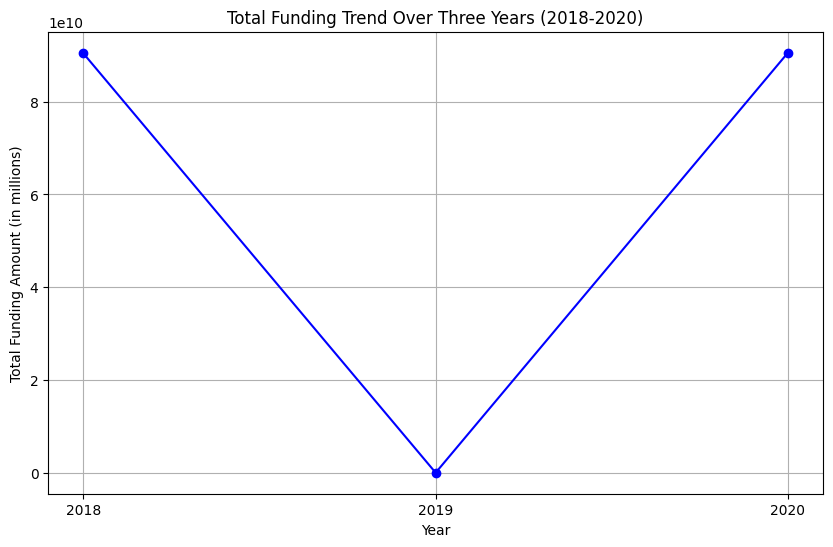

In [658]:

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(total_funding_by_year.index, total_funding_by_year.values, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Total Funding Amount (in millions)')
plt.title('Total Funding Trend Over Three Years (2018-2020)')
plt.grid(True)
plt.show()


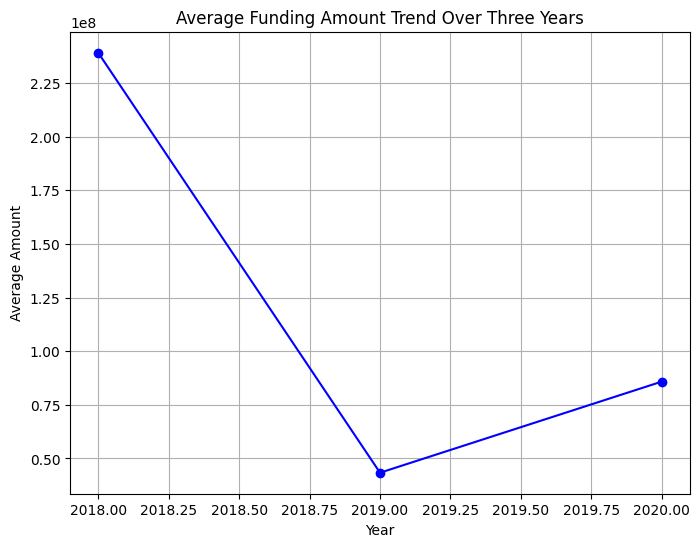

In [652]:

# Calculate the mean of the "Amount" column for each dataframe
mean_2018 = df2018['Amount'].mean()
mean_2019 = df2019['Amount($)'].mean()
mean_2020 = data2020['Amount'].mean()


# Create a new DataFrame to hold the means
mean_df = pd.DataFrame({
    'Year': [2018, 2019, 2020],
    'Mean_Amount': [mean_2018, mean_2019, mean_2020]
})

# Plot the trend
plt.figure(figsize=(8, 6))
plt.plot(mean_df['Year'], mean_df['Mean_Amount'], marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Average Amount')
plt.title('Average Funding Amount Trend Over Three Years')
plt.grid(True)
plt.show()


In [ ]:
#we change the fomat and replace the "-" with unsettled
df_2018["Amount"] = df_2018["Amount"].str.replace("—", "Undisclosed", regex=True)
 
#formatting lambda function replacing values
format_currency = lambda value: value if value == 'Undisclosed' else "${:,.0f}".format(float(value.replace('₹', '').replace(',', '').replace('$', ''))) if isinstance(value, str) else value
 
# Apply the lambda function
df_2018['Amount'] = df_2018['Amount'].apply(format_currency)
df_2018.head()